# Diffusion models

## Introduction

Recently, diffusion models have emerged as the top contender for generative models. Let us explore diffusion models and get some intuition on how they work.

## Preparing the dataset

let us load `torch` as well as some data to approximate. For our purposes, we will use the MNIST dataset

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

device = torch.device('cpu')

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

Let us visualize some examples from the dataset:

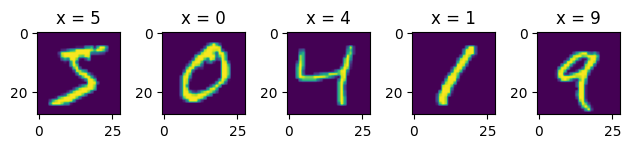

In [3]:
fig = plt.figure()
for i in range(0,5):
    ax = plt.subplot(1,5,i+1)
    data = mnist_trainset[i]
    ax.imshow(data[0])
    ax.set_title(f"x = {data[1]}")
fig.tight_layout()

## Preliminaries

### Forward diffusion process
Let $x_0 \sim q(x)$ be a data point sampled from some distribution. We define the _forward_ diffusion proces, in which we add a small amount of Gaussian noise to the sample. We repeat this $T$ times, which gives us the sequen_channelse of noisy samples $x_1, x_2, \dots, x_T$. The varian_channelse at each step is controlled at each step $t$ by some $\beta_t \in (0,1)$, such that

$$
q(x_t \vert x_{t-1}) = \mathcal{N} (x_t \vert \sqrt{1 - \beta_t} x_{t-1}, \beta_t I).
$$

In other words, at each diffusion step, the conditional distribution $q(x_t \vert x_{t-1})$ is a gaussian with isotropic varian_channelse $\beta_t$ and mean $\sqrt{1 - \beta_t} x_{t-1}$. In the limit $T \rightarrow \infty$, the distribution approaches uniform Gaussian noise, i.e. $x_T \sim \mathcal{N}(0, I)$.

### Reverse diffusion process
We would like to reverse the diffusion process and sample from $q(x_{t-1} \vert x_t)$, starting from a Gaussian noise input $x_T \sim \mathcal{N}(0, I)$. An import observation is that for sufficiently small $\beta_t$, $q(x_{t-1} \vert x_t)$ will also be Gaussian. To estimate it, we would need to use the entire dataset, which is unpractical, so instead we train a model 

$$
p_\theta(x_{t-1} \vert x_t) = \mathcal{N}(x_{t-1} \vert \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)),
$$

to approximate $q(x_{t-1} \vert x_t)$.

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

## In practice

the algorithms for sampling and training the model can be summarized as follows:

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

### Defining samplers
define sampler for the dataset

In [4]:
def sample_mnist(batch_size):
    dataset = torchvision.datasets.MNIST(root = './data/', train = True, download = True)
    result = dataset.data[:batch_size].to(device).view(-1, 1, 28, 28).float()
    return result

n_samples = 4096
training_data = sample_mnist(n_samples)

In [5]:
training_data.shape

torch.Size([4096, 1, 28, 28])

we require the mean and standard deviation of out dataset:

In [6]:
training_mean, training_std = training_data.mean(), training_data.std()

In [7]:
# fig = plt.figure()
# ax = plt.subplot(1,3,1)
# plt.imshow(training_mean.squeeze())
# ax = plt.subplot(1,3,2)
# plt.imshow(training_std.squeeze())
# ax = plt.subplot(1,3,3)
# plt.imshow(((sample_mnist(1) - training_mean) / training_std).squeeze())

### Define the model

We define the model, which will approximate the denoising distribution:

In [8]:
class TimeAppender(nn.Module):

    def __init__(self):

        super().__init__()

    def forward(self, u):
        x, t = u
        if not torch.is_tensor(t):
            t = x.new_full((x.size(0),), t)
        t = t.view((-1,) + (1,) * (x.dim() - 1)).expand_as(x[:,:1])
        return torch.cat((x, t), 1)

class ConvNet(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        
        kernel_size = 5
        n_channels = 64
        
        self.core = nn.Sequential(
            TimeAppender(),
            nn.Conv2d(in_channels + 1, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, out_channels, kernel_size, padding = kernel_size//2),
        )
    
    def forward(self, u):
        return self.core(u)

model = ConvNet(training_data.size(1), training_data.size(1))
model.to(device)

ConvNet(
  (core): Sequential(
    (0): TimeAppender()
    (1): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

### Training the model

wewill use ADAM to optimize our model. Let us first determine the hyperparameters as they were defined in Ho et al.:

In [9]:
T = 100
beta = torch.linspace(1e-4, 0.02, T, device=device)
alpha = 1 - beta
alpha_bar = alpha.log().cumsum(0).exp()
sigma = beta.sqrt()

In [10]:
n_epochs = 100
learning_rate = 1e-3
batch_size = 16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(n_epochs):

    acc_loss = 0

    for x0 in training_data.split(batch_size):
        x0 = (x0 - training_mean) / training_std
        t = torch.randint(T, (x0.size(0),) + (1,) * (x0.dim() - 1), device = x0.device)
        eps = torch.randn_like(x0)
        xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * eps
        output = model((xt, t / (T - 1) - 0.5))
        loss = (eps - output).pow(2).mean()
        acc_loss += loss.item() * x0.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch: {epoch} loss: {acc_loss / training_data.size(0)}')


epoch: 0 loss: 0.27274389227386564


### Sampling with the model

In [ ]:
def generate(size, T, alpha, alpha_bar, sigma, model, train_mean, train_std):

    with torch.no_grad():

        x = torch.randn(size, device=device)

        for t in range(T-1, -1, -1):
            output = model((x, t / (T - 1) - 0.5))
            z = torch.zeros_like(x) if t == 0 else torch.randn_like(x)
            x = 1/torch.sqrt(alpha[t]) \
                * (x - (1-alpha[t]) / torch.sqrt(1-alpha_bar[t]) * output) \
                + sigma[t] * z

        x = x * train_std + train_mean

        return x


In [ ]:
x = generate((32,) + training_data.size()[1:], T, alpha, alpha_bar, sigma, model, training_mean, training_std)

x.shape


torch.Size([32, 1, 28, 28])

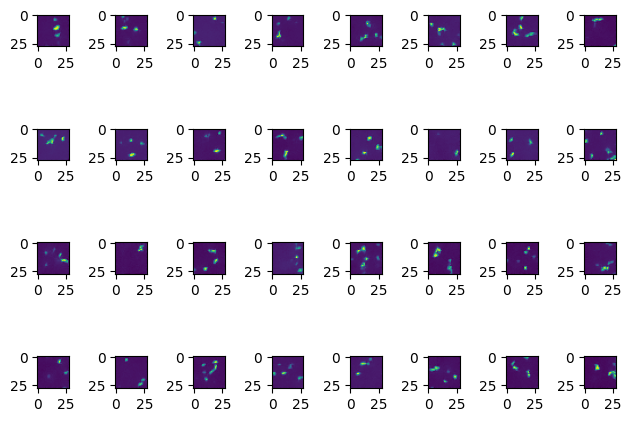

In [ ]:
fig = plt.figure()
for i in range(0,32):
    ax = plt.subplot(4,8,i+1)
    data = mnist_trainset[i]
    ax.imshow(x[i].squeeze())
fig.tight_layout()

In [ ]:
x[1].squeeze()

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, na